In [269]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import meshplot as mp
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f as torch_f
from modelovae import Node, GRASSEncoder, GRASSDecoder, deserialize
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pandas as pd


In [270]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

In [271]:
def plotTree( root, dec ):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec, flag = 0)
    edges=nx.get_edge_attributes(graph,'procesada')

    p = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)

    for arista in graph.edges:
        p.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'])

    return p

def subplotTree( root, dec, d, c = "black"):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec, flag = 0)
    edges=nx.get_edge_attributes(graph,'procesada')

    shading={'point_size':0.1, "point_color": c, "line_color": c}
    #d = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)
    d.add_points( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading = shading)
    for arista in graph.edges:
        d.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'], shading  = shading)


    return d

def traverseleaves(root, leaves):
    if root is not None:
        traverseleaves(root.left, leaves)
        if root.is_leaf():
            leaves.append(root)
        traverseleaves(root.right, leaves)
        return

def traverse(root):
        if root is not None:
            traverse(root.left)
            root.radius=root.radius.reshape(4)
            traverse(root.right)
            return

def traverseradius(root, rlist):
    if root is not None:
        traverseradius(root.left, rlist)
        rlist.append(root.radius[3])
        print("radius", root.radius[3])
        traverseradius(root.right, rlist)
        return 

def traversefeatures(root, features):
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius[3].cpu().item())
        traversefeatures(root.right, features)
        return features

def traversefeatures2(root, features):
    if root is not None:
        traversefeatures2(root.left, features)
        features.append(root.radius[0][3].cpu().item())
        traversefeatures2(root.right, features)
        return features          

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

@count_fn
def createNode(data, radius,left = None, right = None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, left, right)
 


def read_tree(filename, dir):
    with open('./' +dir +'/' +filename, "r") as f:
        byte = f.read() 
        return byte

def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 

def number_nodes(data_loader, batch_size):
    n_no = []
    qzero = 0
    qOne = 0
    qtwo = 0
    for batch in data_loader:
        for tree in batch:
            tree = tree[0]
            count = []
            n = tree.count_nodes(tree, count)
            n_no.append(len(n))
            li = []
            tree.traverseInorderChilds(tree, li)
            zero = [a for a in li if a == 0]
            one = [a for a in li if a == 1]
            two = [a for a in li if a == 2]
            qzero += len(zero)
            qOne += len(one)
            qtwo += len(two)

    nprom = np.mean(n_no)
    qzero /= len(data_loader)*batch_size
    qOne /= len(data_loader)*batch_size
    qtwo /= len(data_loader)*batch_size
    if round(qzero) == 0:
        qzero = 1
    if round(qOne) == 0:
        qOne = 1
    if round(qtwo) == 0:
        qtwo = 1
    mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    return mult
    

In [272]:
def decode_testing(v, max, decoder, mult, min):
    def decode_node(v, max, decoder, mult, min):

        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        
        if label == 1 and createNode.count <= max:
            #print("label 1")
            right, radius = decoder.internalDecoder(v)
                
            d = createNode(1, radius) 
            
            d.right = decode_node(right, max, decoder, mult, min)
            return d

        elif label == 2 and createNode.count <= max:
            #print("label 2")
            left, right, radius = decoder.bifurcationDecoder(v)
                
            d = createNode(1, radius)
            
            d.right = decode_node(right, max, decoder, mult, min)
            d.left = decode_node(left, max, decoder, mult, min)
        
            return d

        elif label == 0 : ##output del classifier
            #print("label 0")
            if createNode.count>min:
                #print("mayor que min")
                radio = decoder.featureDecoder(v)
                return createNode(1,radio)
        
            else:
                #print("menor que min")
                right, radius = decoder.internalDecoder(v)
                d = createNode(1, radius) 
                d.right = decode_node(right, max, decoder, mult, min)
                return d

        '''
        elif label == 0 : ##output del classifier
            print("0", createNode.count)
            radio = decoder.featureDecoder(v)
            return createNode(1,radio)  
        '''

    createNode.count = 0
    v = decoder.sample_decoder(v)
    dec = decode_node (v, max, decoder, mult, min)

    return dec

In [273]:
def my_collate(batch):
    return batch


class tDataset(Dataset):
    def __init__(self, l, dir, transform=None):
        self.names = l
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file, dir))
        self.trees = []

        for tree in self.data:
            deserial = deserialize(tree)
            self.trees.append(deserial)
            

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        name = self.names[idx]
        return tree

batch_size = 1

In [274]:
import uuid
from ipywidgets import Output, HBox
rendertype = 'JUPYTER'

class Subplot():
    def __init__(self, data, view, s):
        if data == None:
            self.rows = []
            self.hboxes = []
        else:
            self.rows = data.rows
        if s[0] != 1 or s[1] != 1:
            if data == None: # Intialize subplot array
                cnt = 0
                for r in range(s[0]):
                    row = []
                    for c in range(s[1]):
                        row.append(Output())
                        cnt += 1
                    self.rows.append(row)

                for r in self.rows:
                    hbox = HBox(r)
                    if rendertype == "JUPYTER":
                        display(hbox)
                    self.hboxes.append(hbox)
        
            out = self.rows[int(s[2]/s[1])][s[2]%s[1]]
            if rendertype == "JUPYTER":
                with out:
                    display(view._renderer)
            self.rows[int(s[2]/s[1])][s[2]%s[1]] = view

    def save(self, filename=""):
        if filename == "":
            uid = str(uuid.uuid4()) + ".html"
        else:
            filename = filename.replace(".html", "")
            uid = filename + '.html'

        s = ""
        imports = True
        for r in self.rows:
            for v in r:
                s1 = v.to_html(imports=imports, html_frame=False)
                s = s + s1
                imports = False

        s = "<html>\n<body>\n" + s + "\n</body>\n</html>"
        with open(uid, "w") as f:
            f.write(s)
        print("Plot saved to file %s."%uid)

    def to_html(self, imports=True, html_frame=True):
        s = ""
        for r in self.rows:
            for v in r:
                s1 = v.to_html(imports=imports, html_frame=html_frame)
                s = s + s1
                imports = False

        return s

In [275]:
def subplot(f, c = 'red', uv=None, n=None, shading={}, s=[1, 1, 0], data=None, **kwargs):
    
    shading={'point_size':0.1, "point_color": c, "line_color": c, "width":400, "height":400}
    view = mp.Viewer(settings = {"width": 500, "height": 500, "antialias": True, "scale": 1.5, "background": "#ffffff",
                "fov": 30})

    obj = view.add_points(np.array([ f.nodes[v]['posicion'] for v in f.nodes]), shading=shading)
    #view.add_lines(v, f, shading=shading)
    for arista in f.edges:
        obj = view.add_lines( f.nodes[arista[0]]['posicion'], f.nodes[arista[1]]['posicion'], shading  = shading)
   
    subplot = Subplot(data, view, s)
    #subplot = view
    return subplot

def sTree( root, dec, s, c, d=None):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec)
    #edges=nx.get_edge_attributes(graph,'procesada')

    #shading={'point_size':0.1, "point_color": c, "line_color": c}
    #d = subplot( graph, c, s)
    if d:
        subplot(graph, c=c, s=s, data = d)
    else:
        
        d = subplot(graph, c=c, s=s)
    
    #for arista in graph.edges:
    #    d.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'], shading  = shading)
    return d

In [276]:
#t_list = os.listdir("./profundidad10/" )[:700]
#dataset = tDataset(t_list, 'profundidad10')
dataset_name = "intra"
p = str(10)
eps = str(0)+str(2)
d = "data/paper/" + dataset_name + "P" +p + "eps" + eps
t_list = os.listdir(d)[:100]
print(len(t_list))
dataset = tDataset(t_list, d )
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
    
i = 0
d = None
d_nodos = []
n_bifo = []
for batch in data_loader:
    for input in batch:
        count = []
        numerar_nodos(input, count)
        d_nodos.append(len(count))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bifo.append(len(two))


100


In [277]:
def distance(node1, node2):
    """
    Calculates the Euclidean distance between two nodes
    """
    if node1 is not None and node2 is not None:
        dist = ((node1.radius[0]-node2.radius[0])**2 + 
                (node1.radius[1]-node2.radius[1])**2 + 
                (node1.radius[2]-node2.radius[2])**2)**0.5
    else:
        dist = 0
    return dist

In [278]:
def tree_length(node):
    '''calcula el largo total del arbol'''
    if node is None:
        return 0

    stack = [(node, None)]
    length = 0

    while stack:
        curr, prev = stack.pop()

        if curr.left:
            stack.append((curr.left, curr))

        if curr.right:
            stack.append((curr.right, curr))

        if prev:
            length += distance(prev, curr)

    return length

In [279]:
def total_length(root, node, d):
    '''
    calcula la distancia del primer a ultimo nodo, arbol sin bifurcaciones
    '''
    if node.left:
        total_length(root, node.left, d)
    if node.isLeaf():
        #d = distance(root, node)
        d.append(distance(root, node))
        return 
    if node.right:
        total_length(root, node.right, d)

def total_path_length(node):
    """
    Calculates the total path length of the tree
    """
    if node is None:
        return 0
    else:
        return distance(node, node.left) + total_path_length(node.left) + distance(node, node.right) + total_path_length(node.right)

def tortuosity(root):
    """
    Calculates the tortuosity of the tree
    """
    total_path_length_value = total_path_length(root)
    d = []
    max_path_length_value = total_length(root,root, d)
    return total_path_length_value / d[0]

calculo tortuosidad, numero de bifurcaciones, largo total para el dataset

In [280]:
tortuosidad = []
n_bif = []
largo = []
n_nodes = []
ratio_radios = []
for batch in data_loader:
    for input in batch:

        graph = nx.Graph()
        input.toGraph(graph, 0 , False, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
       
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
    
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad.append(tortuosity(nodoRaiz))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bif.append(len(two))
        total_path_length_value = tree_length(input)
        largo.append(total_path_length_value.cpu().item())
        count = []
        n = input.countNodes(input, count)
        n_nodes.append(len(n))
        features = []
        traversefeatures(input, features)
        ratio_radios.append(sum(features)/len(features))

calculo tortuosidad, numero de bifurcaciones para los generados

In [281]:
a = [1.,1.,1.]
mult = torch.Tensor(a)
latent_size = 64
Grassdecoder = GRASSDecoder(latent_size=latent_size, hidden_size=256, mult = mult.to(device))
Grassdecoder = Grassdecoder.to(device)
Grassdecoder.eval()
checkpoint = torch.load("output/modelosentrenadosMedIA/" + dataset_name + "P" +p + "eps" + eps+ "-best.pth")
#checkpoint = torch.load("outputs/modelo-best-nuevac.pth")

#checkpoint = torch.load("modelo1.pth")
Grassdecoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']

i = 0
n = 100
tortuosidad_generados = []
n_bif_generados = []
n_nodes_generados = []
largo_generados = []
ratio_radios_generados = []
with torch.no_grad():
    for i in range(n):
        noise = torch.randn(batch_size, latent_size).to(device)
        generated_images = decode_testing(noise, 100, Grassdecoder, mult, 1)
        count = []
        numerar_nodos(generated_images, count)
        graph = nx.Graph()
        generated_images.toGraph(graph, 0 , True, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad_generados.append(tortuosity(nodoRaiz))
        li = []
        generated_images.traverseInorderChilds(generated_images, li)
        two = [a for a in li if a == 2]
        n_bif_generados.append(len(two))
        count = []
        n = generated_images.countNodes(generated_images, count)
        n_nodes_generados.append(len(n))
        traverse(generated_images)
        
        total_path_length_value = tree_length(generated_images)
        largo_generados.append(total_path_length_value.cpu().item())
        features = []
        
        traversefeatures(generated_images, features)
        ratio_radios_generados.append(sum(features)/len(features))

In [282]:
def tr(root):
        if root is not None:
            tr(root.left)
            root.radius[0][3]=root.radius[0][3]/10
            if root.radius[0][3]<0:
                root.radius[0][3]=0
            tr(root.right)
            return

In [283]:

enmax_palette = ["#FF85B1", "#9CCFFC"]
enmax_palette = ["#3EA6A2", "#FF85B1"]

color_codes_wanted = ['pink', 'blue']
col = lambda x: enmax_palette[color_codes_wanted.index(x)]
#sns.set_palette(palette=enmax_palette)

HISTOGRAMAS

LARGO

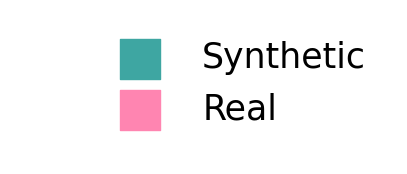

In [284]:

# Plot legend
plt.figure(figsize=(5, 2))  # Adjust size as needed
plt.scatter([], [], label='Synthetic', color=enmax_palette[0], marker='s', s=800)  # Square marker for synthetic samples
plt.scatter([], [], label='Real', color=enmax_palette[1], marker='s', s=800)  # Square marker for real samples
plt.legend(fontsize=25, frameon=False)
plt.axis('off')  # Turn off axis
plt.savefig("./figures/histogramas/nuevos/legend.png")  # Save legend separately

In [285]:
# Define your colors

custom_palette = {"Real": "#9CCFFC", "Synthetic": "#FF85B1"}  

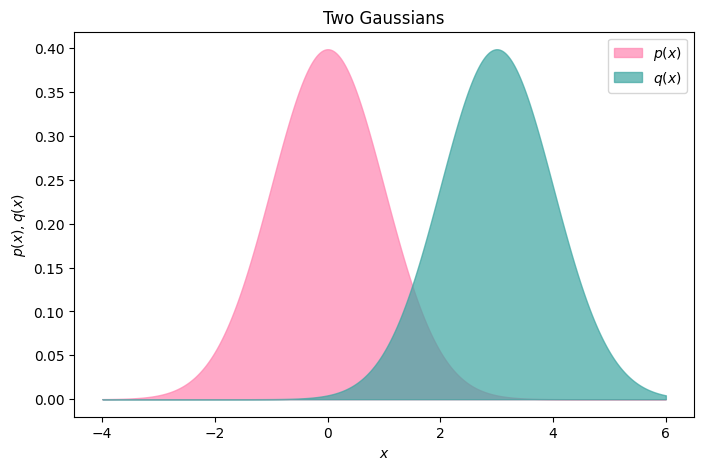

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the x range
x = np.linspace(-4, 6, 1000)

# Define two Gaussian distributions
mu_p, sigma_p = 0, 1    # Mean and standard deviation for p(x)
mu_q, sigma_q = 3, 1    # Mean and standard deviation for q(x)

# Calculate the PDFs
p_x = norm.pdf(x, mu_p, sigma_p)
q_x = norm.pdf(x, mu_q, sigma_q)

# Compute the KL divergences (assuming symmetric divergence)
D_kl_pq = np.sum(p_x * (np.log(p_x) - np.log(q_x))) * (x[1] - x[0])
D_kl_qp = np.sum(q_x * (np.log(q_x) - np.log(p_x))) * (x[1] - x[0])

# Custom color palette
custom_palette = {"Real": "#9CCFFC", "Synthetic": "#FF85B1"} 
custom_palette = {"Real": "#3EA6A2", "Synthetic": "#FF85B1"}

# Plot the two distributions
plt.figure(figsize=(8, 5))
plt.fill_between(x, p_x, color=custom_palette["Synthetic"], alpha=0.7, label='$p(x)$')
plt.fill_between(x, q_x, color=custom_palette["Real"], alpha=0.7, label='$q(x)$')

# Add KL divergence text
#plt.text(-3, 0.35, f'$D_{{KL}}(p||q) \\approx {D_kl_pq:.1f}$', fontsize=10)
#plt.text(-3, 0.3, f'$D_{{KL}}(q||p) \\approx {D_kl_qp:.1f}$', fontsize=10)

# Add labels and annotations
#plt.annotate('$p(x)$', xy=(-1, 0.3), xytext=(-2, 0.3),
#             arrowprops=dict(facecolor=custom_palette["Synthetic"], shrink=0.05),
#             fontsize=10, color=custom_palette["Synthetic"])

#plt.annotate('$q(x)$', xy=(3.5, 0.3), xytext=(4.5, 0.3),
#             arrowprops=dict(facecolor=custom_palette["Real"], shrink=0.05),
#             fontsize=10, color=custom_palette["Real"])

plt.xlabel('$x$')
plt.ylabel('$p(x), q(x)$')
plt.title('Two Gaussians')
plt.legend()
plt.grid(False)
plt.show()


0.9414302791713507

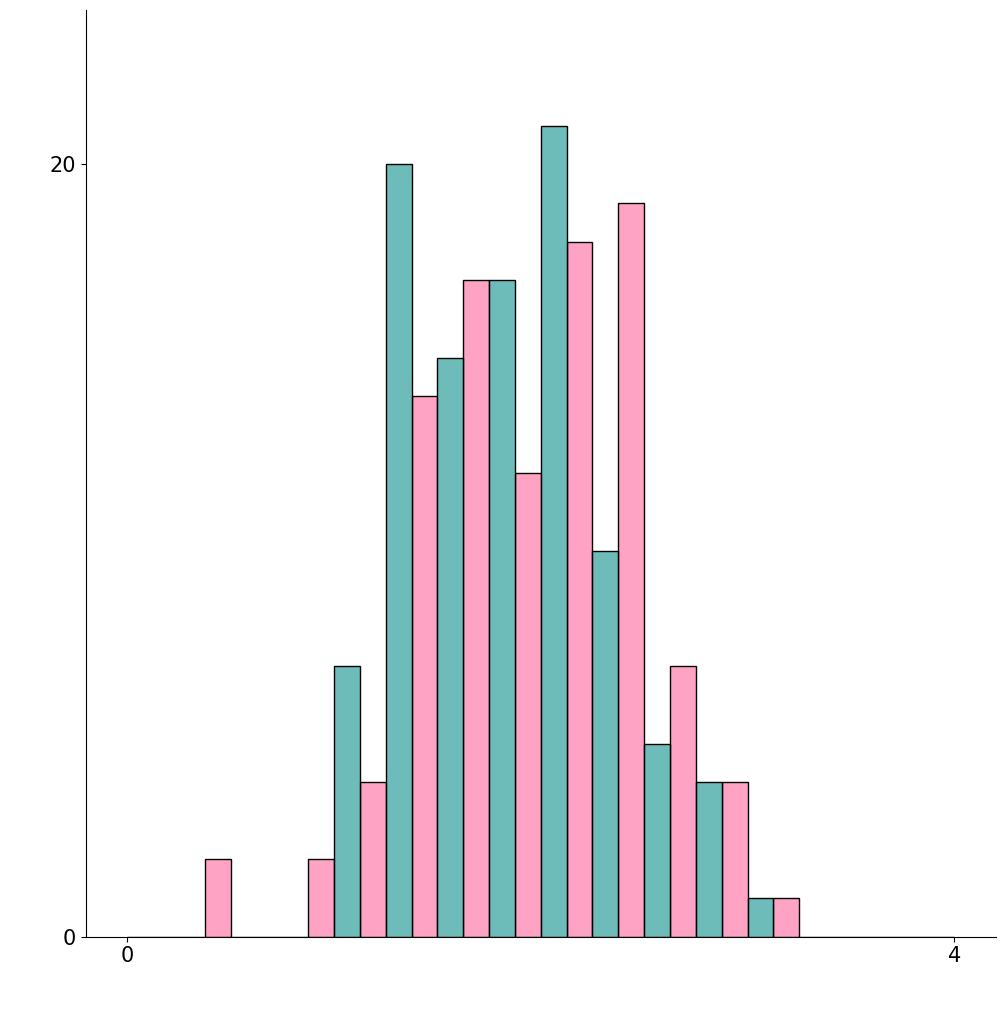

In [287]:
# Create a DataFrame to use with seaborn
data = pd.DataFrame({
    'Length': largo + largo_generados,
    'Type': ['Real'] * len(largo) + ['Synthetic'] * len(largo_generados)
})
bin_width_pixels = 250  # Set your desired bin width in pixels

# Calculate the width of the figure in inches (desired figure width)
figure_width_inch = 10  # Set your desired figure width in inches
figure_dpi = 400  # Set your figure DPI

# Calculate the width of the figure in pixels
figure_width_pixels = figure_width_inch * figure_dpi

# Calculate the number of bins based on the desired bin width in pixels
number_of_bins = int(figure_width_pixels / bin_width_pixels)

# Calculate the bin edges based on the number of bins
min_val = 0
max_val = 4
bins = np.linspace(min_val, max_val, number_of_bins + 1)
# Plot with seaborn
sns.displot(data, x="Length", hue="Type", multiple="dodge", height=10, aspect=1, legend=False, palette=custom_palette,bins= bins)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples"], fontsize=25)
#ax.set_title("Length P{} {}".format(p, dataset_name), fontsize=35)

ax.set_xlabel(" ", fontsize=25)
ax.set_ylabel("  ", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))

# Get the patches for each dataset
patches = ax.patches
l = int(len(patches) / 2)
patches_length = patches[:l]
patches_length_generados = patches[l:]

#plt.xlim(0, 1.5)
plt.ylim(0, 24)

counts = [patch.get_height() for patch in patches]
# Get the counts for ratio_radios
counts_length = [patch.get_height() for patch in patches_length]

# Get the counts for ratio_radios_generados
counts_length_generados = [patch.get_height() for patch in patches_length_generados]

# plt.savefig("./figures/resultados/largo.svg")
plt.savefig("./figures/histogramas/nuevos/largo" + dataset_name + "P" + p + "eps" + eps + ".png", dpi=400)
np.dot(counts_length, counts_length_generados) / (np.linalg.norm(counts_length) * np.linalg.norm(counts_length_generados))

Radio

In [288]:
print("promedio nodos dataset", sum(n_nodes)/len(n_nodes))
print("max nodos dataset", max(n_nodes))
print("min nodos dataset", min(n_nodes))
print("promedio nodos generados", sum(n_nodes_generados)/len(n_nodes_generados))
print("promedio bifurcaciones dataset", sum(n_bif)/len(n_bif))
print("promedio bifurcaciones generados", sum(n_bif_generados)/len(n_bif_generados))

promedio nodos dataset 14.53
max nodos dataset 30
min nodos dataset 6
promedio nodos generados 15.71
promedio bifurcaciones dataset 1.69
promedio bifurcaciones generados 1.63


0.8086356181757468

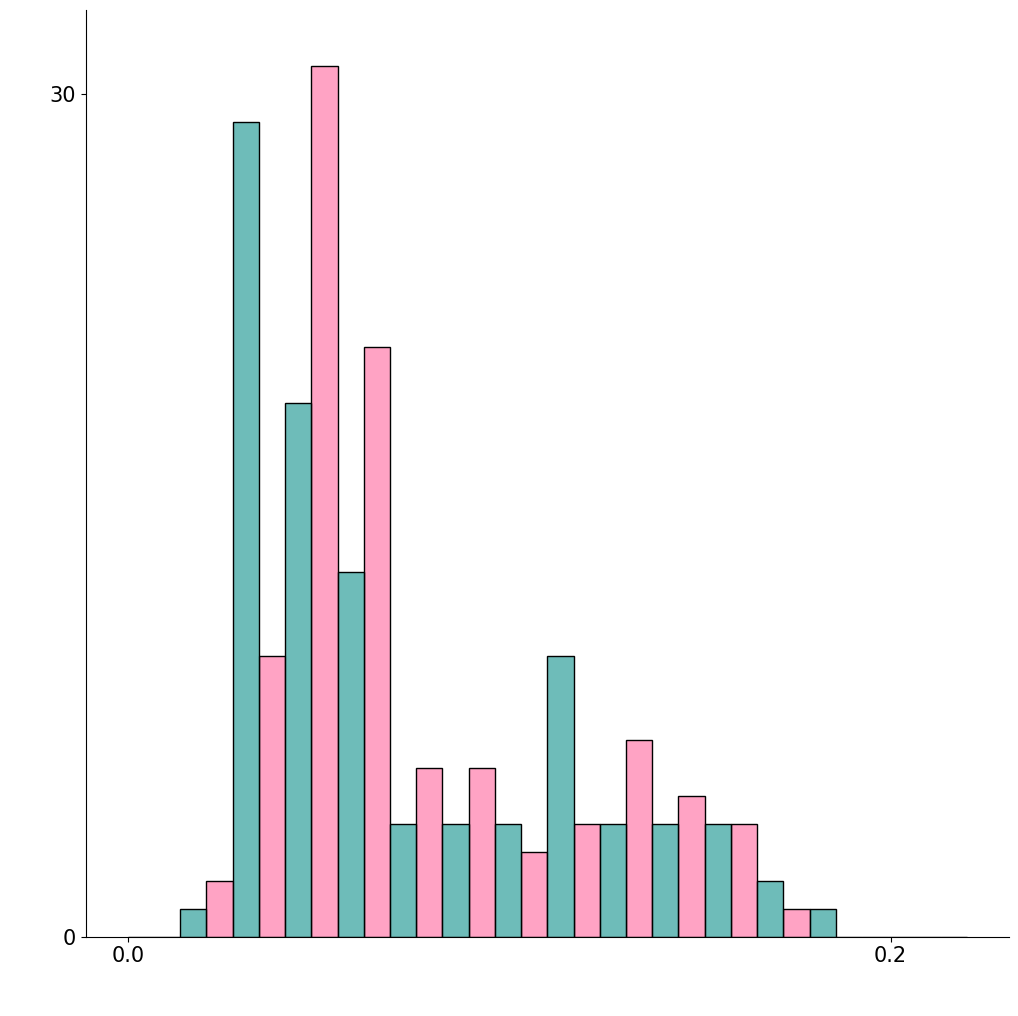

In [298]:
#plt.figure(figsize=(10,20))
data = pd.DataFrame({
    'Length': ratio_radios + ratio_radios_generados,
    'Type': ['Real'] * len(ratio_radios) + ['Synthetic'] * len(ratio_radios_generados)
})

bin_width_pixels = 250  # Set your desired bin width in pixels

# Calculate the width of the figure in inches (desired figure width)
figure_width_inch = 10  # Set your desired figure width in inches
figure_dpi = 400  # Set your figure DPI

# Calculate the width of the figure in pixels
figure_width_pixels = figure_width_inch * figure_dpi

# Calculate the number of bins based on the desired bin width in pixels
number_of_bins = int(figure_width_pixels / bin_width_pixels)

# Calculate the bin edges based on the number of bins
min_val = 0
max_val = 0.22
bins = np.linspace(min_val, max_val, number_of_bins + 1)
# Plot with seaborn
sns.displot(data, x="Length", hue="Type", multiple="dodge", height=10, aspect=1, legend=False, palette=custom_palette, bins=bins)

#sns.displot([ratio_radios, ratio_radios_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()

#ax.set_title("Radius P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Radius", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
ax.set_xlabel("  ", fontsize = 25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
#plt.xlim(0.0, 0.101)
plt.ylim(0, 33)

# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_radius = patches[:l]
patches_radius_generados = patches[l:]

# get the counts for ratio_radios
counts_radius = [patch.get_height() for patch in patches_radius]

# get the counts for ratio_radios_generados
counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

#ax.legend(labels=["Synthetic samples", "Real samples"], fontsize = 25)
#plt.savefig("./figures/radio" + dataset_name + "P" +p + "eps" + eps+ ".svg")
plt.savefig("./figures/histogramas/nuevos/radio" + dataset_name + "P" +p + "eps" + eps+ ".png", dpi=400)

np.dot(counts_radius, counts_radius_generados)/(np.linalg.norm(counts_radius)*np.linalg.norm(counts_radius_generados))

tortuosidad

0.9585217447356638

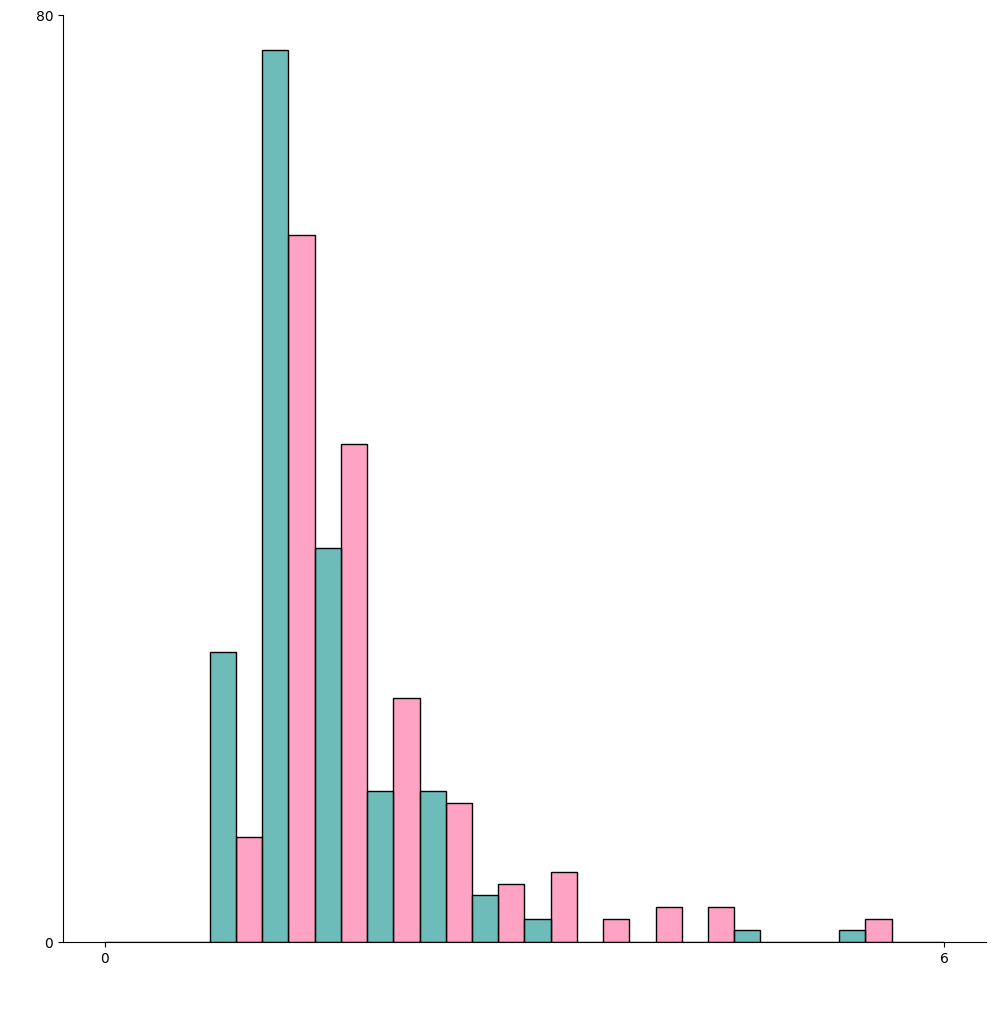

In [300]:
#tortuosidad_generados = [a for a in tortuosidad_generados if a<4]
#tortuosidad = [a for a in tortuosidad if a<4]
data = pd.DataFrame({
    'Length': tortuosidad + tortuosidad_generados,
    'Type': ['Real'] * len(tortuosidad) + ['Synthetic'] * len(tortuosidad_generados)
})
#number_of_bins = 20  # Set the number of bins you want
bin_width_pixels = 250  # Set your desired bin width in pixels

# Calculate the width of the figure in inches (desired figure width)
figure_width_inch = 10  # Set your desired figure width in inches
figure_dpi = 400  # Set your figure DPI

# Calculate the width of the figure in pixels
figure_width_pixels = figure_width_inch * figure_dpi

# Calculate the number of bins based on the desired bin width in pixels
number_of_bins = int(figure_width_pixels / bin_width_pixels)

# Calculate the bin edges based on the number of bins
min_val = 0
max_val = 6
bins = np.linspace(min_val, max_val, number_of_bins + 1)


# Plot with seaborn
sns.displot(data, x="Length", hue="Type", multiple="dodge", bins=bins, height=10, aspect=1, legend=False, palette=custom_palette)
#sns.displot([tortuosidad, tortuosidad_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples"], fontsize = 25)
#ax.set_title("Tortuosity P{} {}".format(p, dataset_name), fontsize=35)
ax.set_xlabel(" ", fontsize = 25)
ax.set_ylabel(" ", fontsize = 15)
ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#plt.xlim(1, 7.5)
plt.ylim(0, 80)

# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_tortuosidad = patches[:l]
patches_tortuosidad_generados = patches[l:]

# get the counts for ratio_radios
counts_tortuosidad = [patch.get_height() for patch in patches_tortuosidad]

# get the counts for ratio_radios_generados
counts_tortuosidad_generados = [patch.get_height() for patch in patches_tortuosidad_generados]

#
plt.savefig("./figures/histogramas/nuevos/tortuosidad" + dataset_name + "P" +p + "eps" + eps+ ".png", dpi=400)
np.dot(counts_tortuosidad, counts_tortuosidad_generados)/(np.linalg.norm(counts_tortuosidad)*np.linalg.norm(counts_tortuosidad_generados))

In [291]:
counts_tortuosidad

[0, 0, 9, 61, 43, 21, 12, 5, 6, 2, 3, 3, 0, 0, 2, 0]

In [292]:
max(tortuosidad)

8.14128188895929

In [293]:
max(tortuosidad_generados)

15.331641049287123

In [294]:
tortuosidad_generados = [ a for a in tortuosidad_generados if a<10]